# Bewildering Grace probabilities

These are notes on the Cyrus Single Story speedrunning route for Octopath Traveler. See, for instance, [these notes from Sanjan](https://docs.google.com/document/d/1hQGU34bZc2Lz_XPg6kNDXp6AnePY2WiE9CM27AG1DmU/edit#heading=h.fvg86xaqdgkz).

## Preliminaries

This section contains technical material necessary for running the notebook. It is irrelevant to the calculation themselves.

In [1]:
from IPython.display import display, Markdown

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

The following helper function prints a dictionary of priorities as percentages

In [2]:
def PrintProbas(dict):
    out = ''
    for key, p in dict.items():
        out += '- **{:s}**: {:.2f}%\n'.format(key,p*100)
    display(Markdown(out))

## Parameters

In this section, I configure the problem.

### Probabilities

Let me first collect the probabilities of the rolls that we are interested in (for an invidual roll of a Bewildering Grace x4). These values are taken from [this spreadsheet](https://docs.google.com/spreadsheets/d/1IUiYWOHEPQ3E4XI4VkmJCdDBs9bOPdhzLhz2vJb7620/). I've collected the values on the 2021-04-11.

Any other result we see as a failure. These are non-overlapping events of a single roll, that is we can sum probabilities to get the probability of the disjunction.

In [3]:
probabilities = {
  'jp2': 0.04,
  'jp5': 0.02,
  'jp100': 0.001,
  'exp5': 0.02,
  'exp100': 0.001,
}

### Routes

My second parameter is to classify the various rolls into their respective routes, and order the routes. In `route_spec` below, the first route is the preferred route, the last one is the least desired one.

In [4]:
route_spec = [
    ('Exp x100', ['exp100']),
    ('JP x5/JP x100', ['jp100','jp5']),
    ('Exp x5', ['exp5']),
    ('JP x2', ['jp2']),
]

 The definition of `route_spec` is a bit idiosyncratic, but from `route_spec`, I can derive two values:

- `routes`: the list of all the routes, ordered by desirability. It is used in the graph generation below to order the legend for the colours. It's purely cosmetic, but eases reading
- `result_types`: a dictionary mapping routes $r$ to rolls which allow a route _at least as good_ as $r$

These are the parameters used in the rest of the exploration: they are idiomatic Python values. But it's much more convenient to derive them from a single `route_spec`.

In [5]:
routes = [ route for route,result in route_spec]

In [6]:
display(routes)

['Exp x100', 'JP x5/JP x100', 'Exp x5', 'JP x2']

In [7]:
from itertools import accumulate
def join(prev, cur):
    return (cur[0], prev[1]+cur[1])
result_types = dict(accumulate(route_spec,join))

In [8]:
display(result_types)

{'Exp x100': ['exp100'],
 'JP x5/JP x100': ['exp100', 'jp100', 'jp5'],
 'Exp x5': ['exp100', 'jp100', 'jp5', 'exp5'],
 'JP x2': ['exp100', 'jp100', 'jp5', 'exp5', 'jp2']}

## Some calculations

Now, what I'm ultimately interested in are the probabilities of the various routes. I've noted it above, but it's worth repeating: all probabilities, from now on, will be the probability of enabling a route, _or a better route_. The goal is to answer questions of the sort: how many attempts must I expect to do if I'm not taking this or that route.

I should say that there is a great does of optimism in these calculations, because they don't take into account the many ways in which Bewildering Grace could prevent you from winning the Gideon fight despite rolling a good roll.

Next we compute the probabilities for _an invdividual roll_ (of which there are 4 per attempted Bewildering Grace) for each of the routes. There is a bit of setup, but it is straightforward: ultimately, we just sum the corresponding probabilities.

In [9]:
def subdict (keys):
    dict = {}
    for k in keys:
        dict[k] = probabilities[k]
    return dict

In [10]:
classified_probabilities = dict([(route, subdict(entries)) for route,entries in result_types.items()])

In [11]:
route_one_roll_probabilities = { route: sum(results.values()) for route,results in classified_probabilities.items() }

In [12]:
PrintProbas(route_one_roll_probabilities)

- **Exp x100**: 0.10%
- **JP x5/JP x100**: 2.20%
- **Exp x5**: 4.20%
- **JP x2**: 8.20%


The next step is to compute the probability for each Bewildering Grace of each route (or better) to be rolled. We do 4 rolls. The probability of at least one of these rolls succeeding is computer using the classic formula for [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial).

$$
1 - (1-p)^n
$$

Where $p$ is the probability of one roll succeeding, and $n$ is the number of rolls (here 4)

I'll also use this same formula to compute the probability of $n$ attempted Bewildering Grace.

In [13]:
def attempts(p, n):
  return (1-(1-p)**n)

In [14]:
route_probabilities = { route: attempts(p, 4) for route,p in route_one_roll_probabilities.items() }

In [15]:
PrintProbas(route_probabilities)

- **Exp x100**: 0.40%
- **JP x5/JP x100**: 8.51%
- **Exp x5**: 15.77%
- **JP x2**: 28.98%


We can see, for instance, refusing to take JPx2 because it is rather a bit slower than the other routes cuts almost by half the probability of each Bewildering Grace attempt. So we will need twice as many attempts to continue.

The notes claim that the JPx2 route is 1min15 slower than the rest. I haven't timed a retry of Gideon, but if a full attempt takes about 1min, then, on average, it is indeed worth it to take a JPx2. The more optimal route, when you are grinding for a very good time, requires more luck, hence is more reset intensive.

## Drawing a graph

Let me summarise the probability in the form of a graph. We can easily read, in the graph, how many attempts it take to have x% change of success (again, with the caveat that bad rolls could make you fail an attempt despite even an Exp x100 being also rolled).

To draw the graph, I need to decide up to how many attempts I'm going to draw. Let us take 60 attempts as it makes the JP x5 route over 99%, we should be able to read whatever we want in the graph with this, as we can read basically the full distribution of all but the Exp x100 route. (I didn't use a formula to find it, I just eyeballed it and tried various values until it looked ok).

In [16]:
max_attempts=60
print('{:.2f}%'.format(attempts(route_probabilities['JP x5/JP x100'],max_attempts) * 100))

99.52%


Making a graph where the Exp x100 goes to close to 100% is not practical: it takes some 600 attempts for this route to be 90%! The graph would be all squeezed up and we wouldn't be able to read out anything from it. So let's forget about this idea.

In [17]:
print('{:.2f}%'.format(attempts(route_probabilities['Exp x100'],600) * 100))

90.94%


In [18]:
def gen():
    for n in range(max_attempts+1):
        for route, p in route_probabilities.items():
            yield { '# Attempts': n, 'Probability': attempts(p,n), 'Route': route }
data = list(gen())

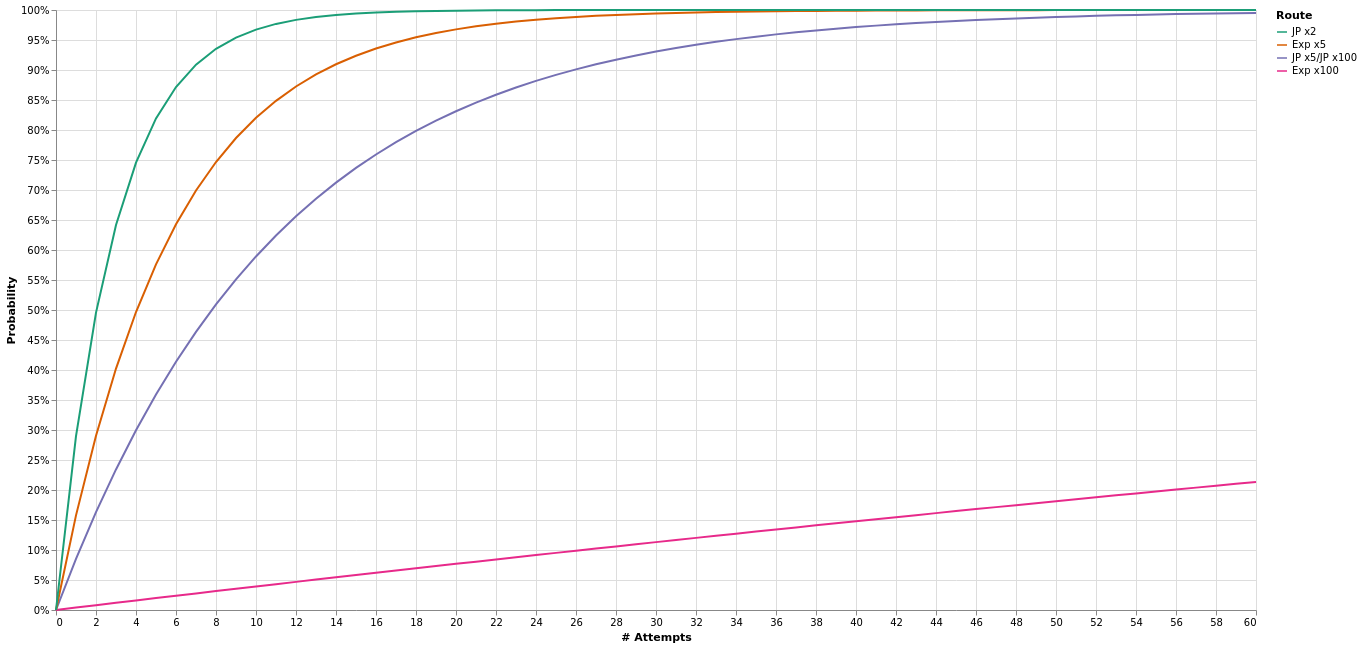

In [19]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 1200,
  "height": 600,
  "padding": 5,
  "data": {
    "values": data
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "# Attempts", "type": "quantitative"},
    "y": {"field": "Probability", "type": "quantitative", "axis": {"format": ".0%"}},
    "color": {"field": 'Route', "sort": reversed(routes), "scale": {"scheme": "dark2"}},
  }
})